In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

100%|██████████| 50/50 [00:58<00:00,  1.18s/it]

Complete


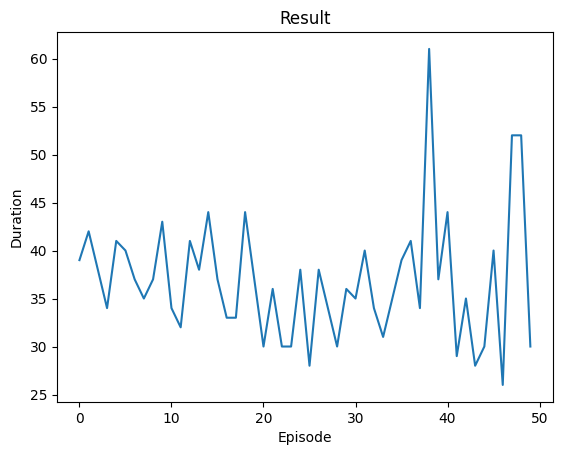

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import game
from tqdm import tqdm

from mancala_rl_agent import RlMancalaPlayer, TAU
from game import GameSimulator

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

agent = RlMancalaPlayer(
    None,
)

p1 = game.RandomPlayer(game.RANDOM_SEED)
game.FIRST_PLAYER_AGENT = True
env: GameSimulator = game.GameSimulator([agent, p1])
agent.env = env

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float, device=device)

    # Play opponent turn if agent is not the first player
    if (game.FIRST_PLAYER_AGENT and env.turn == 1) or (
            not game.FIRST_PLAYER_AGENT and env.turn == 0
        ):
        env.play_next_turn()
        state = env.observation
        state = torch.tensor(state, dtype=torch.float, device=device)

    for t in count():
        print(f"count: {t}")
        print("selecting action...")
        action = agent.select_action(state)
        action_item = action.item()
        # TODO: skip action/update/optimise if there's no valid action available
        print(f"environment applying action: {action_item}...")
        print(f"{env}")
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # simulate opponent turn
        if not done:
            env.play_next_turn()
            observation = env.observation

        if terminated:
            # TODO: when the game is over, we should update next state to be something else
            next_state = torch.tensor(observation, dtype=torch.float, device=device)
        else:
            next_state = torch.tensor(observation, dtype=torch.float, device=device)

        print("storing in memory...")
        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        print("optimizing model....")
        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        print("update weights...")
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        agent.target_net.load_state_dict(target_net_state_dict)

        print(f"am done? {done}")
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()